# Lab Vision Sytems: Session 6

# Today:

### 1: Solution Assignment 4
### 2: Solution Assignment 5
### 3: Unsupervised Learning & Autoencoders
### 4: Denoising Autoencoders
### 5: Variational Autoencoders

# 0: Some comments

### Bug in Previous Session
<img src="bug.png" width=600>




### Next sessions:
 - **Session 7**: Generative Adversarial Networks.   6th July
 - **Session 8**: Deep metric learning and representation learning.  20th July
 - **Extra Session**: Self-Supervised Learning of Visual Representaitons.  ??  

### Course Project:
 - Explained and assigned at the end of Session 8. 
 - Submission deadline: 30th September
   - Code
   - Illustrative Notebook
   - Report (around 8 pages)
 - Review session:
   - Individual meetings where you explain your progress
   - End August or beggining September

# 1: Solution Assignment 4

By Ben Christian Rank & Dushko Klincharov

# 2: Solution Assignment 5

By Prajakta Akush Bhujbal & Sreenivasa Hikkal Venugopala

# 3: Autoencoders 

# 4: Denoising Autoencoders

In [1]:
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import save_image

In [2]:
if not os.path.exists("imgs"):
    os.makedirs("imgs")
if not os.path.exists("imgs/vanilla_dae"):
    os.makedirs("imgs/vanilla_dae")
if not os.path.exists("imgs/vanilla_vae"):
    os.makedirs("imgs/vanilla_vae")

In [3]:
# Downloading and Loading Dataset
mnist_tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Pad(2)
    ])

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=mnist_tf,download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=mnist_tf)

In [4]:
# Fitting data loaders for iterating
B_SIZE = 256

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=B_SIZE, 
                                           shuffle=True) 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=B_SIZE,
                                          shuffle=False)

## Model

In [5]:
def get_act(act_name):
    """ Gettign activation given name """
    assert act_name in ["ReLU", "Sigmoid", "Tanh"]
    activation = getattr(nn, act_name)
    return activation()
    
def get_dropout(drop_p):
    """ Getting a dropout layer """
    if(drop_p):
        drop = nn.Dropout(p=drop_p)
    else:
        drop = nn.Identity()
    return drop

class Reshape(nn.Module):
    """ Module for reshaping a tensor"""
    def __init__(self, size):
        """ Module initializer"""
        super().__init__()
        self.size = size
        
    def forward(self,x):
        """ Rehaping channel spatial dimension"""
        y = x.view(-1, *self.size)
        return y

In [6]:
class VanillaAE(nn.Module):
    """
    Implementation of a fully connect autoencoder for 
    denoising  MNIST images
    """
    
    def __init__(self, in_size=(1,32,32), sizes=[1024, 128, 10], act="ReLU", dropout_in=0.2, dropout_hid=0.5):
        """ Model initlaizer """
        assert np.prod(in_size) == sizes[0]
        super().__init__()
        
        self.in_size = in_size
        self.sizes = sizes
        self.activation = get_act(act) 
        self.drop_in = get_dropout(dropout_in)
        self.drop_hid = get_dropout(dropout_hid)
        
        self.encoder = self._make_encoder()
        self.decoder = self._make_decoder()
        return
        
    def _make_encoder(self):
        """ Defining encoder """
        layers = [nn.Flatten()]
        
        # adding fc+act+drop for each layer
        for i in range(len(self.sizes)-1):
            layers.append( nn.Linear(in_features=self.sizes[i], out_features=self.sizes[i+1]) )
            layers.append( self.activation )
            if(i == 0):
                layers.append( self.drop_in)
            else:
                layers.append( self.drop_hid)
                
        # replacing last act and dropout with sigmoid
        layers = layers[:-2] + [nn.Sigmoid()]
        encoder = nn.Sequential(*layers)
        return encoder
    
    def _make_decoder(self):
        """ Defining decoder """
        layers = []
        
        # adding fc+act+drop for each layer
        for i in range(1, len(self.sizes)):
            layers.append( nn.Linear(in_features=self.sizes[-i], out_features=self.sizes[-i-1]) )
            layers.append( self.activation )
            if(i == 0):
                layers.append( self.drop_in)
            else:
                layers.append( self.drop_hid)
                
        # replacing last act and dropout with sigmoid
        layers = layers[:-2] + [nn.Sigmoid()]
        decoder = nn.Sequential(*layers)
        return decoder
        
    def forward(self, x):
        """ Forward pass """
        
        z = self.encoder(x)
        x_hat_flat = self.decoder(z)
        x_hat = x_hat_flat.view(-1, *self.in_size)
        
        return x_hat, z

In [7]:
ae = VanillaAE()

In [8]:
# ae

## Utils

In [9]:
def add_noise(img, mean=0, sigma=0.3):
    """ Adding AWGN to images"""
    noisy_img = img + torch.normal(mean * torch.ones(img.shape), sigma)
    return noisy_img.clamp(0,1)

In [10]:
def train_epoch(model, train_loader, optimizer, criterion, epoch, device):
    """ Training a model for one epoch """
    
    loss_list = []
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, _) in progress_bar:
        noisy_images = add_noise(images)
        noisy_images = noisy_images.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass
        recons, _ = model(noisy_images)
         
        # Calculate Loss
        loss = criterion(recons.cpu(), images)
        loss_list.append(loss.item())
         
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
        
        progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")
        
    mean_loss = np.mean(loss_list)
    return mean_loss, loss_list


@torch.no_grad()
def eval_model(model, eval_loader, criterion, device, epoch=None, savefig=False, savepath=""):
    """ Evaluating the model for either validation or test """
    loss_list = []
    
    for i, (images, _) in enumerate(eval_loader):
        noisy_images = add_noise(images)
        noisy_images = noisy_images.to(device)
        
        # Forward pass 
        recons, _ = model(noisy_images)
                 
        loss = criterion(recons.cpu(), images)
        loss_list.append(loss.item())
        
        if(i==0 and savefig):
            save_image( images[:64].cpu(), os.path.join(savepath, f"input_{epoch}.png") )
            save_image( noisy_images[:64].cpu(), os.path.join(savepath, f"noisy_{epoch}.png") ) 
            save_image( recons[:64].cpu(), os.path.join(savepath, f"recons{epoch}.png") )
            
    # Total correct predictions and loss
    loss = np.mean(loss_list)
    
    return loss


def train_model(model, optimizer, scheduler, criterion, train_loader,
                valid_loader, num_epochs, savepath):
    """ Training a model for a given number of epochs"""
    
    train_loss = []
    val_loss =  []
    loss_iters = []
    
    for epoch in range(num_epochs):
           
        # validation epoch
        model.eval()  # important for dropout and batch norms
        log_epoch = (epoch % 5 == 0 or epoch == num_epochs - 1)
        loss = eval_model(
                model=model, eval_loader=valid_loader, criterion=criterion,
                device=device, epoch=epoch, savefig=log_epoch, savepath=savepath
            )
        val_loss.append(loss)
        
        # training epoch
        model.train()  # important for dropout and batch norms
        mean_loss, cur_loss_iters = train_epoch(
                model=model, train_loader=train_loader, optimizer=optimizer,
                criterion=criterion, epoch=epoch, device=device
            )
        scheduler.step(val_loss[-1])
        train_loss.append(mean_loss)
        loss_iters = loss_iters + cur_loss_iters
        
        if(log_epoch):
            print(f"    Train loss: {round(mean_loss, 5)}")
            print(f"    Valid loss: {round(loss, 5)}")
    
    print(f"Training completed")
    return train_loss, val_loss, loss_iters


def smooth(f, K=5):
    """ Smoothing a function using a low-pass filter (mean) of size K """
    kernel = np.ones(K) / K
    f = np.concatenate([f[:int(K//2)], f, f[int(-K//2):]])  # to account for boundaries
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[K//2: -K//2]  # removing boundary-fixes
    return smooth_f


def set_random_seed(random_seed=None):
    """
    Using random seed for numpy and torch
    """
    if(random_seed is None):
        random_seed = CONFIG["random_seed"]
    os.environ['PYTHONHASHSEED'] = str(random_seed)
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    return


def count_model_params(model):
    """ Counting the number of learnable parameters in a nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params

## Training

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
ae = VanillaAE(in_size=(1,32,32), sizes=[1024, 256, 128, 128, 64], act="ReLU", dropout_in=0.2, dropout_hid=0.5)
ae = ae.to(device)

In [13]:
# count_model_params(ae)
print(f"Encoder has {count_model_params(ae.encoder)} params")
print(f"Decoder has {count_model_params(ae.decoder)} params")

Encoder has 320064 params
Decoder has 321024 params


In [14]:
# regression loss function
criterion = nn.MSELoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(ae.parameters(), lr=3e-3, weight_decay=1e-5)

# Decay LR by a factor of 10 after 5 epochs with no improvement
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.1, verbose=True)

In [15]:
train_loss, val_loss, loss_iters = train_model(
        model=ae, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=test_loader, num_epochs=20,
        savepath="imgs/vanilla_dae"
    )

Epoch 1 Iter 235: loss 0.03598. : 100%|██████████| 235/235 [00:07<00:00, 32.58it/s]


    Train loss: 0.05963
    Valid loss: 0.18932


Epoch 6 Iter 235: loss 0.03180. : 100%|██████████| 235/235 [00:07<00:00, 32.93it/s]


    Train loss: 0.03041
    Valid loss: 0.02634


Epoch 11 Iter 235: loss 0.02715. : 100%|██████████| 235/235 [00:07<00:00, 33.46it/s]


    Train loss: 0.02875
    Valid loss: 0.02439


Epoch 16 Iter 235: loss 0.03010. : 100%|██████████| 235/235 [00:06<00:00, 33.90it/s]


    Train loss: 0.02817
    Valid loss: 0.02333


Epoch 20 Iter 235: loss 0.02926. : 100%|██████████| 235/235 [00:07<00:00, 32.64it/s]

    Train loss: 0.02801
    Valid loss: 0.02319
Training completed


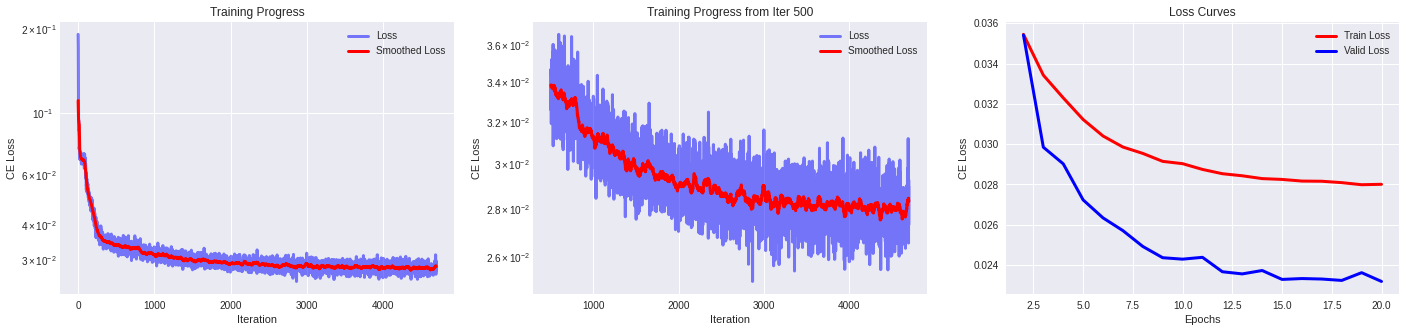

In [16]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,3)
fig.set_size_inches(24,5)

smooth_loss = smooth(loss_iters, 31)
ax[0].plot(loss_iters, c="blue", label="Loss", linewidth=3, alpha=0.5)
ax[0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
ax[0].legend(loc="best")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("CE Loss")
ax[0].set_yscale("log")
ax[0].set_title("Training Progress")

smooth_loss = smooth(loss_iters, 31)
START = 500
N_ITERS = len(loss_iters)
ax[1].plot(np.arange(START, N_ITERS), loss_iters[START:], c="blue", label="Loss", linewidth=3, alpha=0.5)
ax[1].plot(np.arange(START, N_ITERS), smooth_loss[START:], c="red", label="Smoothed Loss", linewidth=3, alpha=1)
ax[1].legend(loc="best")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("CE Loss")
ax[1].set_yscale("log")
ax[1].set_title(f"Training Progress from Iter {START}")

epochs = np.arange(len(train_loss)) + 1
ax[2].plot(epochs[1:], train_loss[1:], c="red", label="Train Loss", linewidth=3)
ax[2].plot(epochs[1:], val_loss[1:], c="blue", label="Valid Loss", linewidth=3)
ax[2].legend(loc="best")
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("CE Loss")
ax[2].set_title("Loss Curves")


plt.show()

## Some Analysis

In [17]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [18]:
imgs_flat, latents, labels = [], [], []
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        _, z = ae(imgs)
        imgs_flat.append(imgs.cpu().view(imgs.shape[0],-1))
        latents.append(z.cpu())
        labels.append(lbls)
        
imgs_flat = np.concatenate(imgs_flat)    
latents = np.concatenate(latents)
labels = np.concatenate(labels)

In [40]:
COLORS = ['r', 'b', 'g', 'y', 'purple', 'orange', 'k', 'brown', 'grey',
          'c', "gold", "fuchsia", "lime", "darkred", "tomato", "navy"]

def display_projections(points, labels, ax=None, legend=None):
    """ Displaying low-dimensional data projections """
    
    legend = [f"Class {l}" for l in np.unique(labels)] if legend is None else legend
    if(ax is None):
        _, ax = plt.subplots(1,1,figsize=(12,6))
    
    for i,l in enumerate(np.unique(labels)):
        idx = np.where(l==labels)

        ax.scatter(points[idx, 0], points[idx, 1], label=legend[int(l)], c=COLORS[i])
    ax.legend(loc="best")

In [41]:
pca_imgs = PCA(n_components=2).fit_transform(imgs_flat)
pca_latents = PCA(n_components=2).fit_transform(latents)

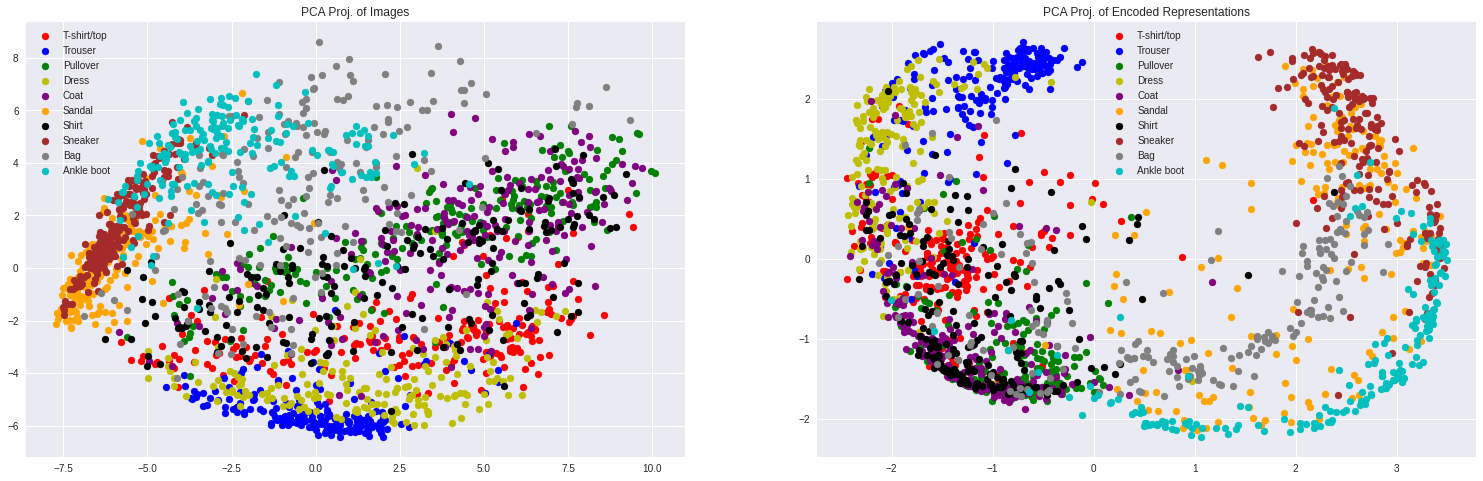

In [45]:
N = 2000
fig,ax = plt.subplots(1,2,figsize=(26,8))
display_projections(pca_imgs[:N], labels[:N], ax=ax[0], legend=test_dataset.classes)
ax[0].set_title("PCA Proj. of Images")
display_projections(pca_latents[:N], labels[:N], ax=ax[1], legend=test_dataset.classes)
ax[1].set_title("PCA Proj. of Encoded Representations")
plt.show()

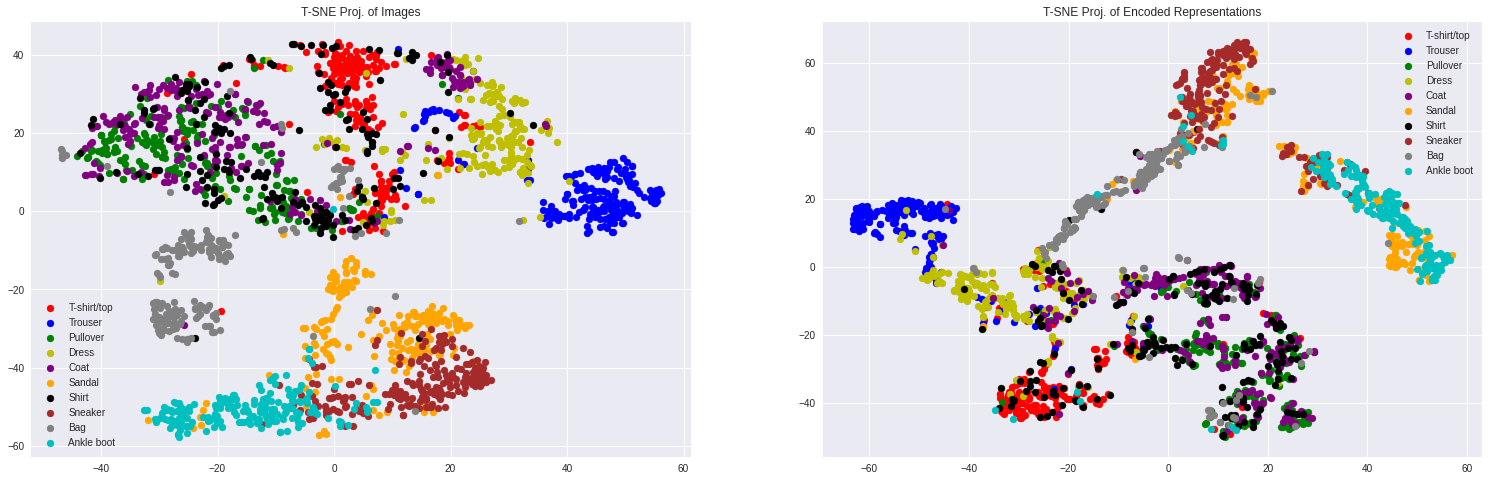

In [46]:
N = 2000
tsne_imgs = TSNE(n_components=2).fit_transform(imgs_flat[:N])
tsne_latents = TSNE(n_components=2).fit_transform(latents[:N])

fig,ax = plt.subplots(1,2,figsize=(26,8))
display_projections(tsne_imgs[:N], labels[:N], ax=ax[0], legend=test_dataset.classes)
ax[0].set_title("T-SNE Proj. of Images")
display_projections(tsne_latents[:N], labels[:N], ax=ax[1], legend=test_dataset.classes)
ax[1].set_title("T-SNE Proj. of Encoded Representations")
plt.show()

### Clustering

In [47]:
kmeans_imgs = KMeans(n_clusters=10, random_state=0).fit(imgs_flat)
kmeans_latent = KMeans(n_clusters=10, random_state=0).fit(latents)

In [48]:
ari_imgs = adjusted_rand_score(labels, kmeans_imgs.labels_)
ari_latents = adjusted_rand_score(labels, kmeans_latent.labels_)

In [49]:
print(f"Clustering images achieves  ARI={round(ari_imgs*100,2)}%")
print(f"Clustering latents achieves ARI={round(ari_latents*100,2)}%")

Clustering images achieves  ARI=35.13%
Clustering latents achieves ARI=34.82%


In [50]:
print(f"Compression ratio: {latents.shape[-1]}/{imgs_flat.shape[-1]}  = {round(latents.shape[-1]/imgs_flat.shape[-1] * 100, 2)}%")

Compression ratio: 64/1024  = 6.25%


# 5: Variational Autoencoder

## Model

In [55]:
class VanillaVAE(nn.Module):
    """
    Implementation of a fully connect autoencoder for 
    denoising  MNIST images
    """
    
    def __init__(self, in_size=(1,32,32), sizes=[1024, 128, 10], act="ReLU"):
        """ Model initlaizer """
        assert np.prod(in_size) == sizes[0]
        super().__init__()
        
        self.in_size = in_size
        self.sizes = sizes
        self.activation = get_act(act) 
        
        self.encoder = self._make_encoder()
        self.decoder = self._make_decoder()
        self.fc_mu = nn.Linear(sizes[-2], sizes[-1])
        self.fc_sigma = nn.Linear(sizes[-2], sizes[-1])
        return
        
    def _make_encoder(self):
        """ Defining encoder """
        layers = [nn.Flatten()]
        
        # adding fc+act+drop for each layer
        for i in range(len(self.sizes)-2):
            layers.append( nn.Linear(in_features=self.sizes[i], out_features=self.sizes[i+1]) )
            layers.append( self.activation )
                
        # replacing last act and dropout with sigmoid
        encoder = nn.Sequential(*layers)
        return encoder
    
    def _make_decoder(self):
        """ Defining decoder """
        layers = []
        
        # adding fc+act+drop for each layer
        for i in range(1, len(self.sizes)):
            layers.append( nn.Linear(in_features=self.sizes[-i], out_features=self.sizes[-i-1]) )
            layers.append( self.activation )
                
        # replacing last act and dropout with sigmoid
        layers = layers[:-1] + [nn.Sigmoid()]
        decoder = nn.Sequential(*layers)
        return decoder
        
    
    def reparameterize(self, mu, log_var):
        """ Reparametrization trick"""
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)  # random sampling happens here
        z = mu + std * eps
        return z

    
    def forward(self, x):
        """ Forward pass """
        
        # encoding and computng statistics
        x_enc = self.encoder(x)
        mu = self.fc_mu(x_enc)
        log_var = self.fc_sigma(x_enc)
        
        # reparametrization trick
        z = self.reparameterize(mu, log_var)
        
        # decoding
        x_hat_flat = self.decoder(z)
        x_hat = x_hat_flat.view(-1, *self.in_size)
        
        return x_hat, (z, mu, log_var)

In [56]:
vae = VanillaVAE()

In [57]:
vae

VanillaVAE(
  (activation): ReLU()
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1024, out_features=128, bias=True)
    (2): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1024, bias=True)
    (3): Sigmoid()
  )
  (fc_mu): Linear(in_features=128, out_features=10, bias=True)
  (fc_sigma): Linear(in_features=128, out_features=10, bias=True)
)

## Training

In [65]:
def vae_loss_function(recons, target, mu, log_var, lambda_recons=1, lambda_elbo=1):
    """
    Combined loss function for joint optimization of 
    reconstruction and ELBO
    """
#     recons_loss = F.mse_loss(recons, target, reduction="mean")  # if you use this, remove final sigmoid
    b_size = recons.shape[0]
    recons_loss = F.binary_cross_entropy(recons.view(b_size,-1), target.view(b_size,-1), reduction='sum')
    elbo = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return (lambda_recons * recons_loss + lambda_elbo * elbo) / b_size, (recons_loss, elbo)

In [66]:
def train_epoch(model, train_loader, optimizer, criterion, epoch, device):
    """ Training a model for one epoch """
    
    loss_list = []
    recons_loss = []
    vae_loss = []
    
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, _) in progress_bar:
        images = images.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass
        recons, (z, mu, log_var) = model(images)
         
        # Calculate Loss
        loss, (mse, kld) = criterion(recons, images, mu, log_var)
        loss_list.append(loss.item())
        recons_loss.append(mse.item())
        vae_loss.append(kld.item())
        
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
        
        progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")
        
    mean_loss = np.mean(loss_list)
    
    return mean_loss, loss_list


@torch.no_grad()
def eval_model(model, eval_loader, criterion, device, epoch=None, savefig=False, savepath=""):
    """ Evaluating the model for either validation or test """
    loss_list = []
    recons_loss = []
    vae_loss = []
    
    for i, (images, _) in enumerate(eval_loader):
        images = images.to(device)
        
        # Forward pass 
        recons, (z, mu, log_var) = model(images)
                 
        loss, (mse, kld) = criterion(recons, images, mu, log_var)
        loss_list.append(loss.item())
        recons_loss.append(mse.item())
        vae_loss.append(kld.item())
        
        if(i==0 and savefig):
            save_image( recons[:64].cpu(), os.path.join(savepath, f"recons{epoch}.png") )
            
    # Total correct predictions and loss
    loss = np.mean(loss_list)
        
    return loss


In [67]:
vae = VanillaVAE(in_size=(1,32,32), sizes=[1024, 256, 128, 64, 2], act="ReLU")
vae = vae.to(device)

In [68]:
count_model_params(vae)

608516

In [69]:
savepath = "imgs/vanilla_vae"
model = vae

In [70]:
optimizer = torch.optim.Adam(vae.parameters(), lr=3e-3)

# Decay LR by a factor of 10 after 5 epochs with no improvement
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.1, verbose=True)

In [71]:
train_loss, val_loss, loss_iters = train_model(
        model=model, optimizer=optimizer, scheduler=scheduler, criterion=vae_loss_function,
        train_loader=train_loader, valid_loader=test_loader, num_epochs=20, savepath=savepath
    )

Epoch 1 Iter 235: loss 279.22614. : 100%|██████████| 235/235 [00:06<00:00, 36.91it/s]


    Train loss: 314.31886
    Valid loss: 711.01021


Epoch 6 Iter 235: loss 273.73120. : 100%|██████████| 235/235 [00:06<00:00, 37.89it/s]


    Train loss: 261.84315
    Valid loss: 263.21002


Epoch 11 Iter 235: loss 260.97955. : 100%|██████████| 235/235 [00:06<00:00, 35.72it/s]


    Train loss: 258.25761
    Valid loss: 260.11585


Epoch 16 Iter 235: loss 263.36407. : 100%|██████████| 235/235 [00:06<00:00, 38.80it/s]


    Train loss: 259.53531
    Valid loss: 261.09228


Epoch 18 Iter 235: loss 245.45384. : 100%|██████████| 235/235 [00:06<00:00, 38.60it/s]


Epoch    18: reducing learning rate of group 0 to 3.0000e-04.


Epoch 20 Iter 235: loss 257.53119. : 100%|██████████| 235/235 [00:06<00:00, 37.46it/s]

    Train loss: 255.22114
    Valid loss: 257.15718
Training completed


In [72]:
filtered_loss_iters = np.array(loss_iters)
med = np.median(filtered_loss_iters)
filtered_loss_iters[loss_iters < med / 2] = med

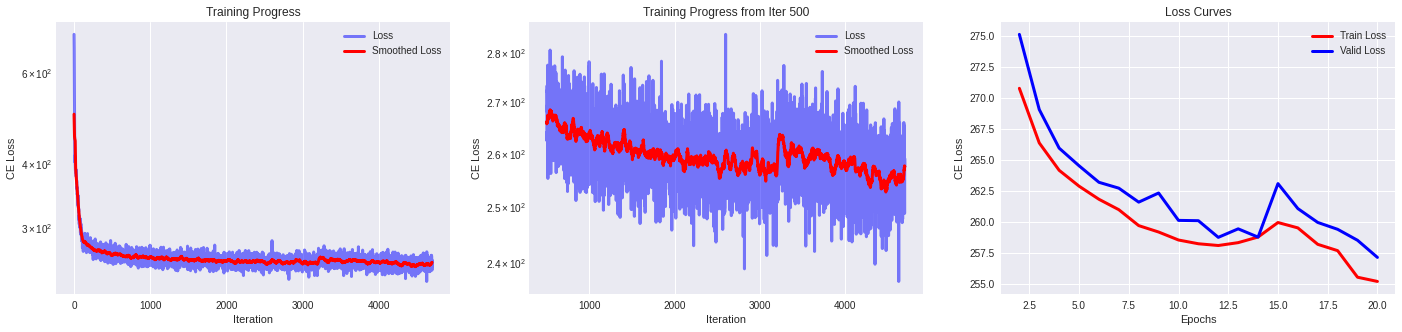

In [73]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,3)
fig.set_size_inches(24,5)

smooth_loss = smooth(filtered_loss_iters, 31)
ax[0].plot(filtered_loss_iters, c="blue", label="Loss", linewidth=3, alpha=0.5)
ax[0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
ax[0].legend(loc="best")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("CE Loss")
ax[0].set_yscale("log")
ax[0].set_title("Training Progress")

smooth_loss = smooth(filtered_loss_iters, 31)
START = 500
N_ITERS = len(filtered_loss_iters)
ax[1].plot(np.arange(START, N_ITERS), filtered_loss_iters[START:], c="blue", label="Loss", linewidth=3, alpha=0.5)
ax[1].plot(np.arange(START, N_ITERS), smooth_loss[START:], c="red", label="Smoothed Loss", linewidth=3, alpha=1)
ax[1].legend(loc="best")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("CE Loss")
ax[1].set_yscale("log")
ax[1].set_title(f"Training Progress from Iter {START}")

epochs = np.arange(len(train_loss)) + 1
ax[2].plot(epochs[1:], train_loss[1:], c="red", label="Train Loss", linewidth=3)
ax[2].plot(epochs[1:], val_loss[1:], c="blue", label="Valid Loss", linewidth=3)
ax[2].legend(loc="best")
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("CE Loss")
ax[2].set_title("Loss Curves")


plt.show()

## Inference 

In [74]:
if not os.path.exists("imgs/inferecence_vae"):
    os.makedirs("imgs/inferecence_vae")

In [75]:
with torch.no_grad():
    for i in range(5):
        z = torch.randn(64, 2).to(device)
        sample = vae.decoder(z)
    
        save_image(sample.view(64, 1, 32, 32), f"imgs/inferecence_vae/inference_{i}.png")

## Analysis

In [76]:
imgs_flat, latents, labels = [], [], []
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        _, (z, _, _) = model(imgs)
        imgs_flat.append(imgs.cpu().view(imgs.shape[0],-1))
        latents.append(z.cpu())
        labels.append(lbls)
        
imgs_flat = np.concatenate(imgs_flat)    
latents = np.concatenate(latents)
labels = np.concatenate(labels)

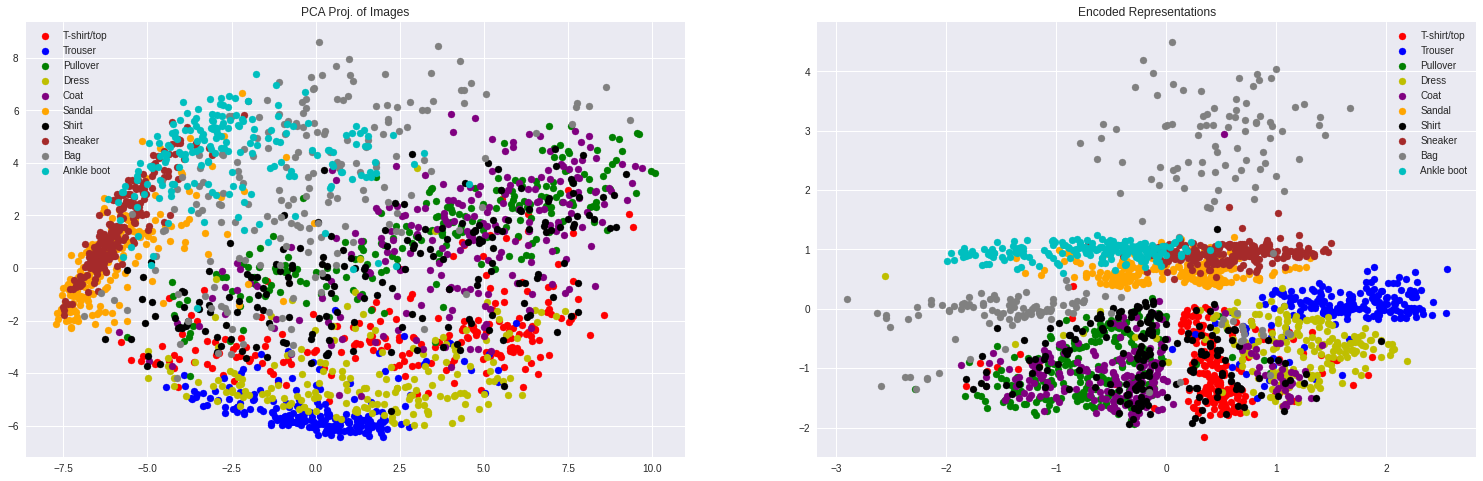

In [78]:
pca_imgs = PCA(n_components=2).fit_transform(imgs_flat)

# N = 2000
fig,ax = plt.subplots(1,2,figsize=(26,8))
display_projections(pca_imgs[:N], labels[:N], ax=ax[0], legend=test_dataset.classes)
ax[0].set_title("PCA Proj. of Images")
display_projections(latents[:N], labels[:N], ax=ax[1], legend=test_dataset.classes)
ax[1].set_title("Encoded Representations")
plt.show()

## Interpolation

In [79]:
@torch.no_grad()
def plot_reconstructed(model, xrange=(-3, 3), yrange=(-2, 2), N=12):
    """
    Sampling equispaced points from the latent space givent the xange and yrange, 
    decoding latents and visualizing distribution of the space
    """
    SIZE = 32
    grid = np.empty((N*SIZE, N*SIZE))
    
    for i, y in enumerate(np.linspace(*yrange, N)):
        for j, x in enumerate(np.linspace(*xrange, N)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = model.decoder(z).cpu()
            x_hat = x_hat.view(32,32)
            
            grid[(N-1-i)*SIZE:(N-i)*SIZE, j*SIZE:(j+1)*SIZE] = x_hat
           
    plt.figure(figsize=(12,20))
    plt.imshow(grid, extent=[*yrange, *xrange], cmap="gray")
    plt.axis("off")

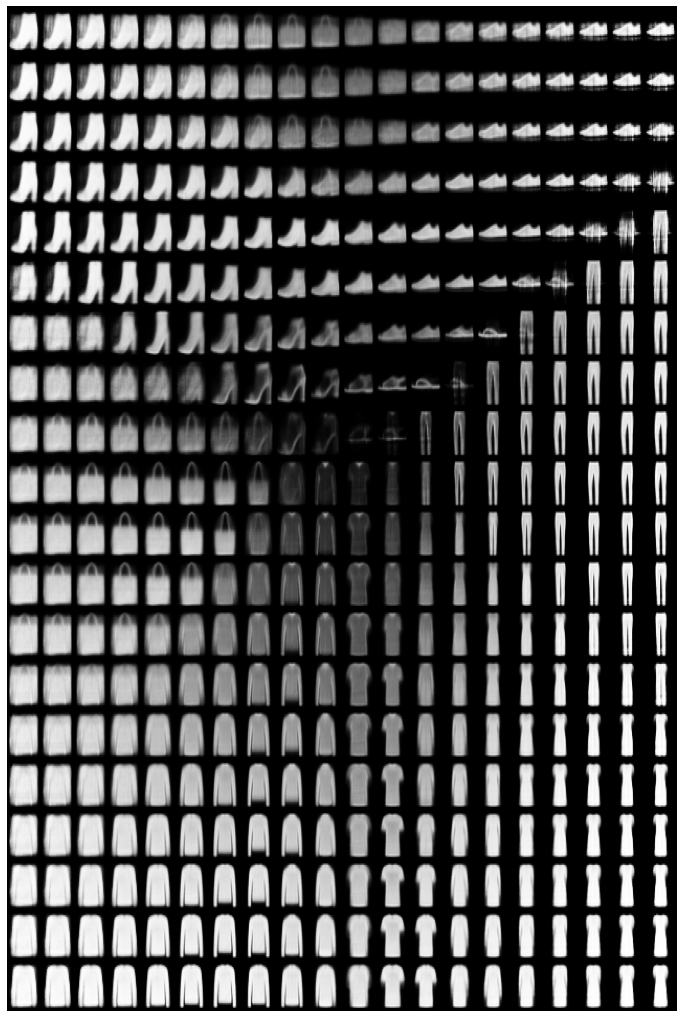

In [80]:
plot_reconstructed(model, xrange=(-3, 3), yrange=(-2, 2), N=20)

In [81]:
img1 = test_dataset[0][0]
img2 = test_dataset[13][0]

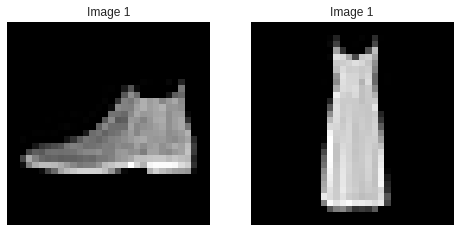

In [82]:
plt.subplot(1,2,1)
plt.imshow(img1[0], cmap="gray")
plt.axis("off")
plt.title(f"Image 1")
plt.subplot(1,2,2)
plt.imshow(img2[0], cmap="gray")
plt.axis("off")
plt.title(f"Image 1")
plt.show()

In [83]:
with torch.no_grad():
    encoded = model.encoder(torch.stack([img1, img2]).to(device))
    mus, log_var = model.fc_mu(encoded), model.fc_sigma(encoded)
std = torch.exp(0.5*log_var)
latents = mus + std
latent1, latent2 = latents[0], latents[1]

In [86]:
@torch.no_grad()
def sample_interpolation(model, p1, p2, N=15):
    """ Sampling N points from the line that connects p1 and p2 """
    
    z = torch.stack([p1 * t + p2 * (1-t) for t in torch.linspace(0, 1, N).to(device)])
    decoded = model.decoder (z)
    decoded_imgs = decoded.cpu().view(-1,32,32)
    return decoded_imgs

In [87]:
decoded_imgs = sample_interpolation(model, latent2, latent1, N=12)

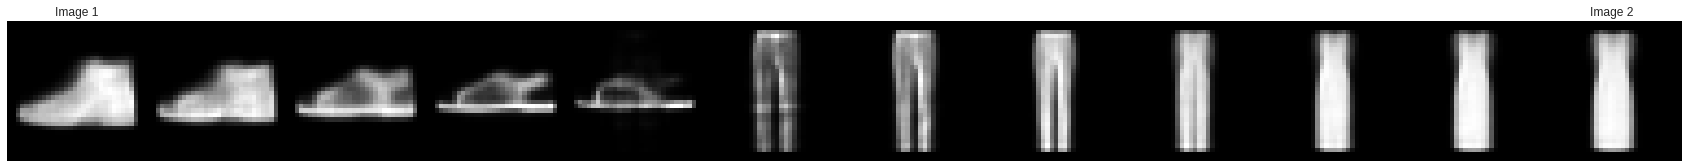

In [88]:

fig, ax = plt.subplots(1, len(decoded_imgs), figsize=(30,3))
for i,img in enumerate(decoded_imgs):
    ax[i].imshow(img, cmap="gray")
    ax[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

plt.subplots_adjust(wspace=0., hspace=0)
ax[0].set_title("Image 1")
ax[-1].set_title("Image 2")
plt.show()

# Assignment 6

 - a) Write **Convolutional** Variational Autoencoder for CIFAR-10 dataset
    - Use Conv. layers for encoder and TransposedConv. layers in decoder
    - You are allowed to use one FC-layer in each module for the bottleneck
 - b) Investigate latent space and visualize some interpolations
 - c) Use the latent space for clustering and classification
 - d) Compare it with the FC-VAE seen in class. You might need to make some changes in the number of layers and the dimensionalities
 - Extra point:
    - Make a quantitative comparison between models using one of the following metrics: 
      - Inception Score: https://arxiv.org/abs/1606.03498
      - Fréchet Inception Distance: https://arxiv.org/abs/1706.08500
      - Perceptual Similarity: https://arxiv.org/abs/1801.03924
 - Extra point:
   - Evaluate and compare a Conv. VAE which uses PixelShuffle layers for upsampling
   

#### **Due Date**: Sunday 11th July at 23:59
#### Submit it by mail using the subject: **CudaLab: Assignment6**
####  Send me the following: Jupyter Notebook after running, Jupyter export as **html**, any other .py files or images used.

# References
 - https://www.deeplearningbook.org/
 - https://towardsdatascience.com/all-you-want-to-know-about-deep-learning-8d68dcffc258
 - https://github.com/lyeoni/pytorch-mnist-VAE
 - https://towardsdatascience.com/reparameterization-trick-126062cfd3c3

<div class=alert style="background-color:#F5F5F5; border-color:#C8C8C8">
    <b>Angel Villar-Corrales</b><br>
    <ul>
       <li> <b>Email</b>: villar@ais.uni-bonn.de
       <li> <b>Website</b>: angelvillarcorrales.com
    </ul>
</div>  